In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_historical.csv")

In [3]:
df = pd.read_csv("../Data/raw/president_polls.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [4]:
df['date'] = pd.to_datetime(df['end_date'])
df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_52921/2456293558.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [5]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [6]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(df_2way[['DEM', 'GOP']].sum(axis=1), axis=0)

In [7]:
df_2way

,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,election_date,date,year,month,day,week,DEM,GOP,type
0,87361,202461,1102,Emerson,IVR/Online Panel/Text-to-Web,US,rv,1370.0,2024,11/5/24,2024-07-08,2024,7,-120,-18,0.498000,0.502000,2way
1,87351,202394,1189,Morning Consult,Online Panel,US,rv,9738.0,2024,11/5/24,2024-07-07,2024,7,-121,-18,0.488372,0.511628,2way
2,87350,202393,1189,Morning Consult,Online Panel,US,rv,3440.0,2024,11/5/24,2024-07-06,2024,7,-122,-18,0.488372,0.511628,2way
3,87358,202426,1329,Bendixen & Amandi International,Live Phone/Online Panel,US,lv,850.0,2024,11/5/24,2024-07-06,2024,7,-122,-18,0.494118,0.505882,2way
4,87349,202392,1189,Morning Consult,Online Panel,US,rv,3480.0,2024,11/5/24,2024-07-05,2024,7,-123,-18,0.494253,0.505747,2way
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,84655,185592,1189,Morning Consult,Online Panel,PA,rv,733.0,2024,11/5/24,2023-11-07,2023,11,-364,-52,0.483516,0.516484,2way
941,84656,185594,1189,Morning Consult,Online Panel,WI,rv,628.0,2024,11/5/24,2023-11-07,2023,11,-364,-52,0.494624,0.505376,2way
942,84731,187500,1189,Morning Consult,Online Panel,US,rv,3400.0,2024,11/5/24,2023-11-06,2023,11,-365,-53,0.494118,0.505882,2way
943,84599,185063,1189,Morning Consult,Online Panel,US,rv,5160.0,2024,11/5/24,2023-11-05,2023,11,-366,-53,0.488372,0.511628,2way


In [8]:
df = pd.concat([df_2way])
df.dropna()
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Apply the function to create 'type_id' column
df['type_bt'] = (df['type'] == '2way').astype(int)

Two way Biden vs Trump, Biden leads by 5.5%

In [9]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,945.000000,945.000000
mean,0.488871,0.511129
std,0.038205,0.038205
min,0.289855,0.320000
25%,0.476744,0.500000
50%,0.489130,0.510870
75%,0.500000,0.523256
max,0.680000,0.710145


In [10]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

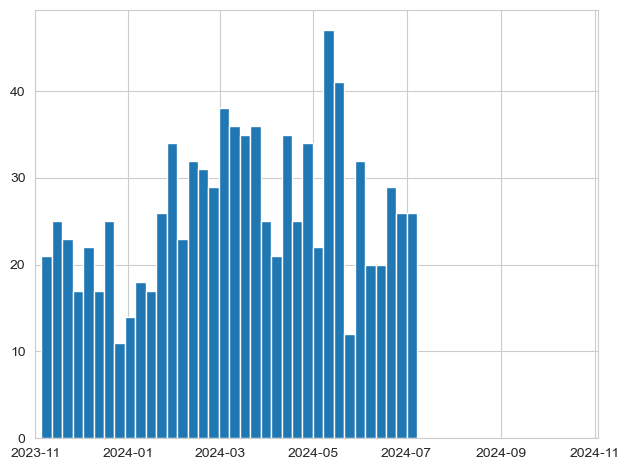

In [11]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 1), dt.datetime(2024, 11, 3))

plt.tight_layout()
plt.show()

In [12]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Live Phone/Text-to-Web,Probability Panel,IVR/Text-to-Web,IVR/Online Panel,IVR/Online Panel/Text-to-Web,Online Panel/Text-to-Web,IVR/Online Panel/Email,Online Panel/Text-to-Web/Text
pollster,,,,,,,,,,,
All,945,508,66,64,53,34,29,21,20,20,18
Morning Consult,308,308,0,0,0,0,0,0,0,0,0
Emerson,62,0,0,0,0,0,10,20,1,20,0
YouGov,56,56,0,0,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,49,0,0,0,0,30,14,0,0,0,0
Big Data Poll,28,0,0,0,0,0,0,0,0,0,18
Ipsos,27,0,0,0,27,0,0,0,0,0,0
Siena/NYT,24,0,24,0,0,0,0,0,0,0,0
McLaughlin,20,14,0,6,0,0,0,0,0,0,0


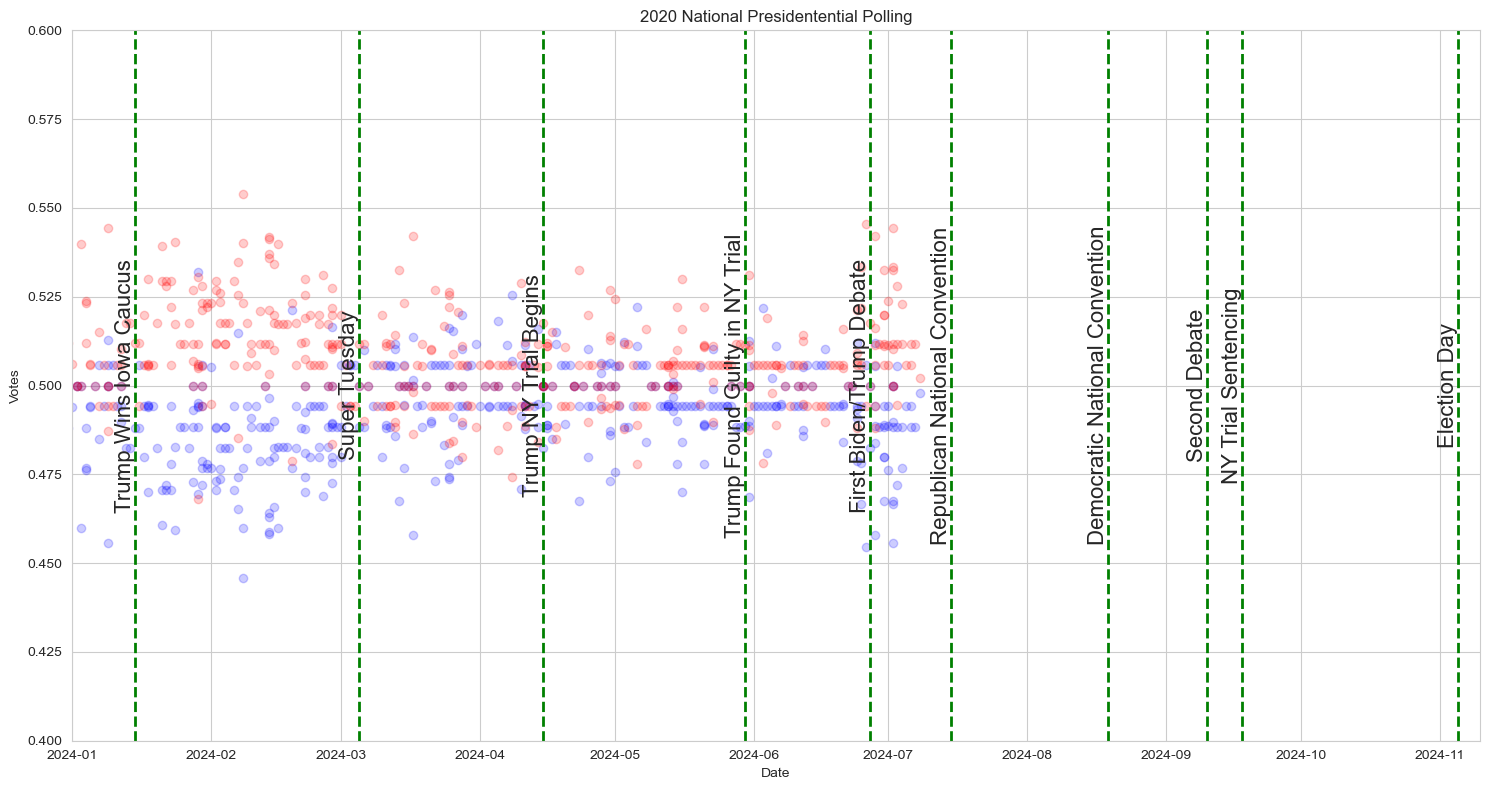

In [13]:
dem_votes = df_2way.query("state == 'US'")["DEM"].values
gop_votes = df_2way.query("state == 'US'")["GOP"].values

dates = df_2way.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")

# Set limits and labels
ax.set_ylim(0.4, 0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

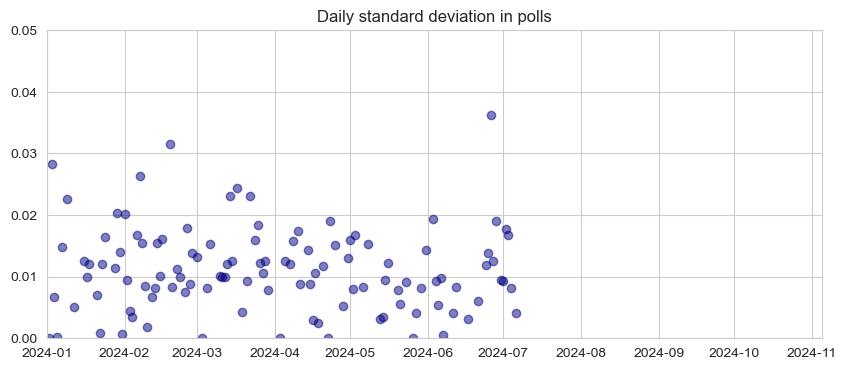

In [14]:
rolling_std = (
    df_2way.query("state == 'US'")[["date", "DEM", "GOP"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'navy',
    alpha=0.5,
)

ax.set_ylim(0, .05)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

We can see here that polling methodology is irrelevant, they all perform about the same.

In [15]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.480658,0.519342
IVR/Text,0.505495,0.494505
Live Phone,0.489206,0.510794
Live Phone/Online Panel,0.504635,0.495365
Online Panel,0.492619,0.507381
Probability Panel,0.497168,0.502832
Text-to-Web/Online Ad,0.452858,0.547142


We can see that Trump fairly consistently out-performs on App Panel polls.

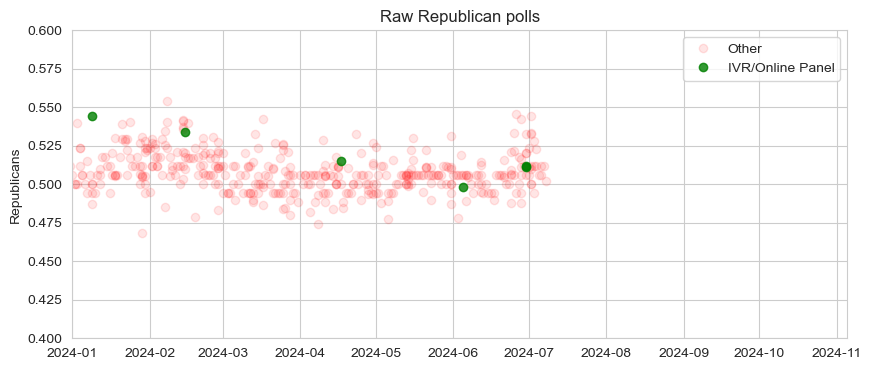

In [16]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(.4, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [17]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [18]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,type_bt,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,2024-07-08,87361,202461,1102,Emerson,IVR/Online Panel/Text-to-Web,US,rv,1370.0,2024,...,2way,0,1,-0.00,0.51,0.49,-0.02,-0.01,0.01,0.02
1,2024-07-07,87351,202394,1189,Morning Consult,Online Panel,US,rv,9738.0,2024,...,2way,1,1,-0.02,0.51,0.49,-0.02,-0.00,0.00,0.00
2,2024-07-06,87350,202393,1189,Morning Consult,Online Panel,US,rv,3440.0,2024,...,2way,2,1,-0.02,0.51,0.49,-0.02,-0.00,0.00,0.00
3,2024-07-06,87358,202426,1329,Bendixen & Amandi International,Live Phone/Online Panel,US,lv,850.0,2024,...,2way,3,1,-0.01,0.51,0.49,-0.02,-0.01,0.01,0.01
4,2024-07-05,87349,202392,1189,Morning Consult,Online Panel,US,rv,3480.0,2024,...,2way,4,1,-0.01,0.51,0.49,-0.02,-0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,2023-11-07,84655,185592,1189,Morning Consult,Online Panel,PA,rv,733.0,2024,...,2way,940,1,-0.03,0.52,0.48,-0.04,-0.01,0.01,0.01
941,2023-11-07,84656,185594,1189,Morning Consult,Online Panel,WI,rv,628.0,2024,...,2way,941,1,-0.01,0.52,0.48,-0.04,-0.02,0.02,0.03
942,2023-11-06,84731,187500,1189,Morning Consult,Online Panel,US,rv,3400.0,2024,...,2way,942,1,-0.01,0.50,0.50,-0.01,0.00,-0.00,-0.00
943,2023-11-05,84599,185063,1189,Morning Consult,Online Panel,US,rv,5160.0,2024,...,2way,943,1,-0.02,0.50,0.50,-0.01,0.01,-0.01,-0.02


In [19]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,-0.022258


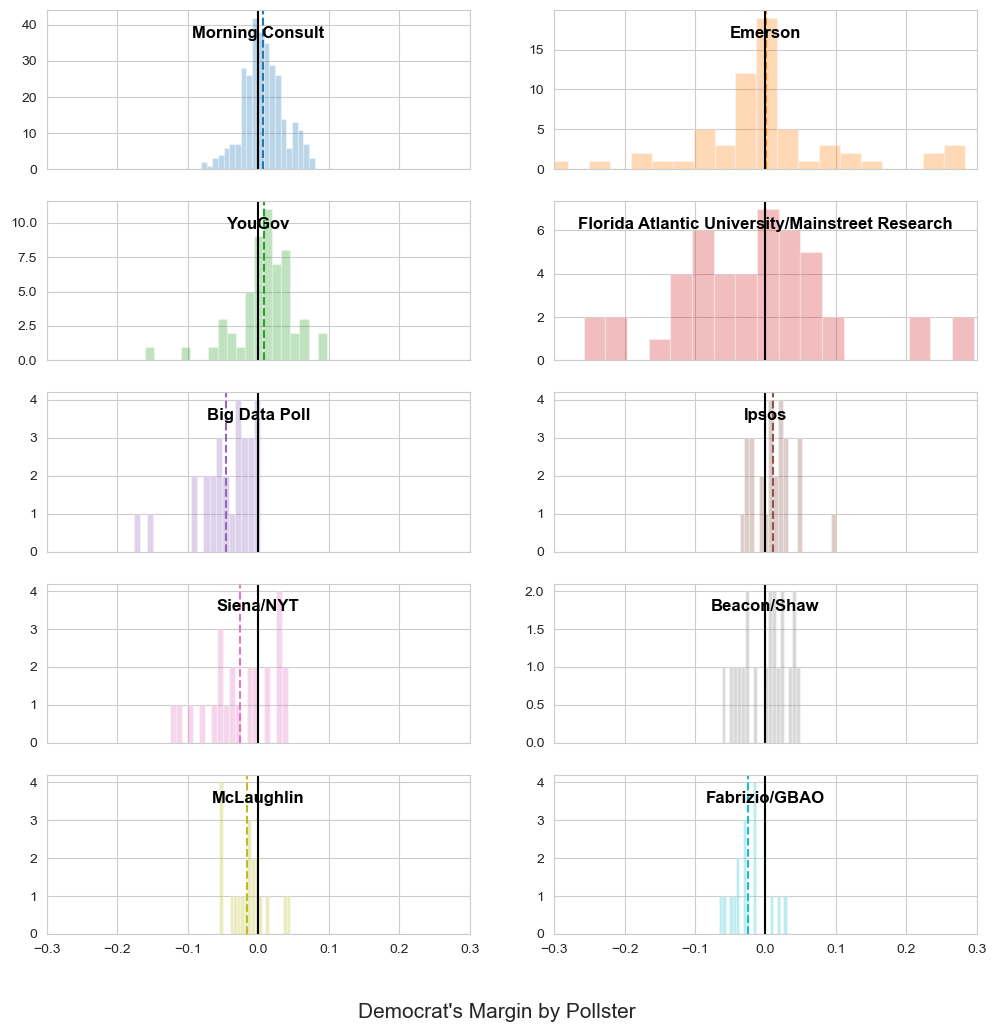

In [20]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

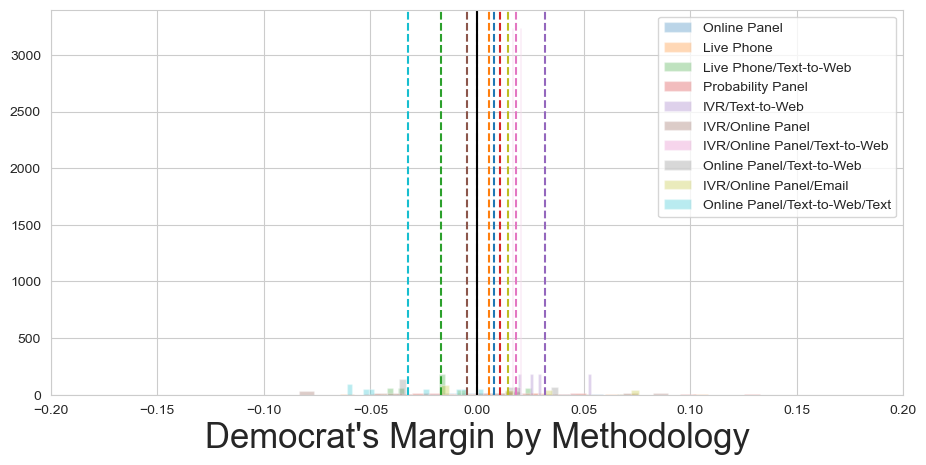

In [21]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [22]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1], ['DEM','GOP']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [23]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")
    dem_day_effect = pm.GaussianRandomWalk("dem_day_effect", sigma=dem_sigma, init_dist=pm.Normal.dist(mu=-0.025, sigma=0.1), dims="day")

    dem_polling = pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'],
        dims="observation",
    )

    polling_error = pm.Normal("polling_error", 0, .05)

    # Sampling
    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, dem_day_effect, polling_error]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 414 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


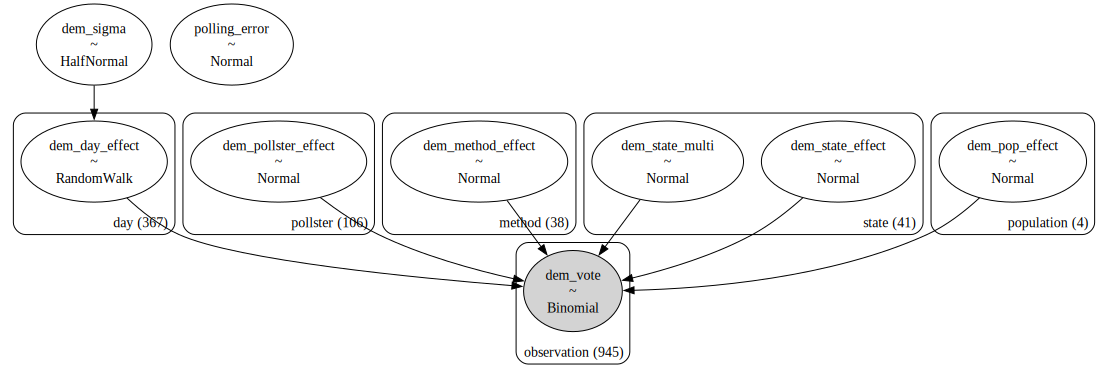

In [24]:
pm.model_to_graphviz(twoway)

In [25]:
z = pd.DataFrame()
z['state'] = idata.posterior.state
z['state_multi'] = idata.posterior.dem_state_multi.mean(axis=0).mean(axis=0).values
z['state_effect'] = idata.posterior.dem_state_effect.mean(axis=0).mean(axis=0).values

In [26]:
z.sort_values(by='state_multi')

,state,state_multi,state_effect
14,MI,0.935738,0.031678
33,TX,0.940088,-0.117610
3,CA,0.948364,0.513340
2,AZ,0.956027,-0.008038
15,MN,0.958912,0.127069
24,NY,0.967629,0.338656
12,MD,0.977501,0.596702
4,CO,0.978130,0.254810
38,WA,0.982135,0.295535
20,NH,0.982421,0.128609


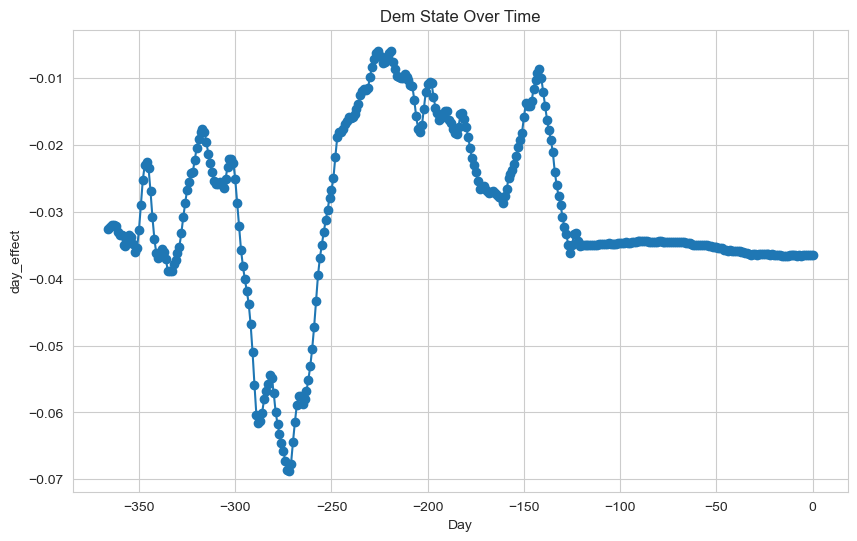

In [27]:
z = pd.DataFrame()
z['day'] = idata.posterior.day
z['day_effect'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(z['day'], z['day_effect'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('day_effect')
plt.title('Dem State Over Time')
plt.grid(True)
plt.show()

In [28]:
states = df['state'].unique()
parties = ['dem','gop', 'margin']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [95]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

for d in tqdm(day):
#for d in [-115]:
    
    for state in states:
        
        for party in ['dem']:
            df_results[f"{state}_{party}"] = inv_logit(
                (idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
                 idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School")
                )/2 +
                (idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
                 idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
                 idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2)
                )/3 + 
                idata.posterior[f"{party}_pop_effect"].sel(population="rv") +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}") +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}") *
                idata.posterior[f"{party}_day_effect"].sel(day=d)
               + idata.posterior[f"polling_error"]).values.ravel()
                
        df_results[f"{state}_gop"] = 1 - df_results[f"{state}_dem"]
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_mean.loc[d] = df_results.mean()
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 367/367 [02:39<00:00,  2.31it/s]


In [96]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)


In [97]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_52921/1395024144.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_52921/1395024144.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

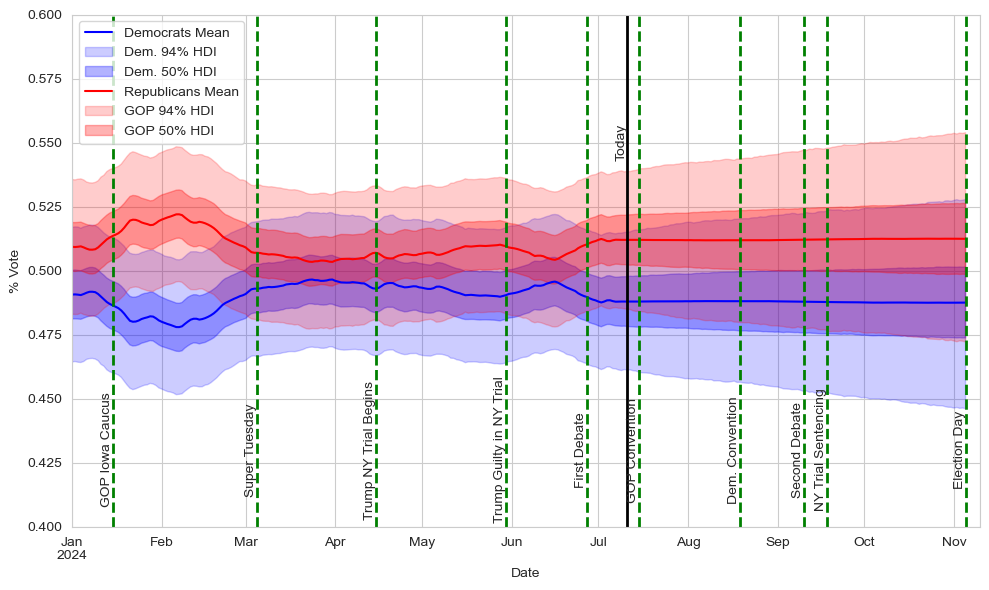

In [98]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=0.1, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=0.1, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0.4,0.6)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.43, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.55, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

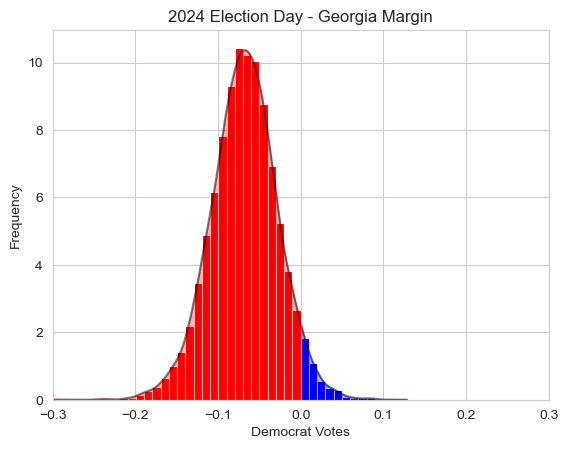

In [119]:
# TX, CA, MN, MI, FL, GA

graph_state = 'GA'

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_results[f"{graph_state}_margin"], binwidth=.01, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 0:
        patch.set_facecolor('red')
    elif x > 0:
        patch.set_facecolor('blue')
    elif x == 0:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_results[f"{graph_state}_margin"], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 0), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 0), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x == 0), color='lime', alpha=1)


# Adding titles and labels
plt.title('2024 Election Day - Georgia Margin')
plt.xlabel('Democrat Votes')
plt.xlim(-.3, .3)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_ga.png')

In [100]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [101]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

3       AR
6       CT
7       DE
11      ID
12      IL
15      KS
16      KY
19    ME-1
20    ME-2
25      MS
30    NE-1
31    NE-2
32    NE-3
39      ND
55      WY
56      DC
Name: state_code, dtype: object

In [102]:
df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'

df_winner[['CT', 'DE', 'IL','ME-1', 'NE-2', 'DC']] = 'dem'

state_order = df_state['state_code'].to_list

In [103]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_52921/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_52921/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [104]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)

In [105]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(12.659999999999998, 0.01, 87.33)

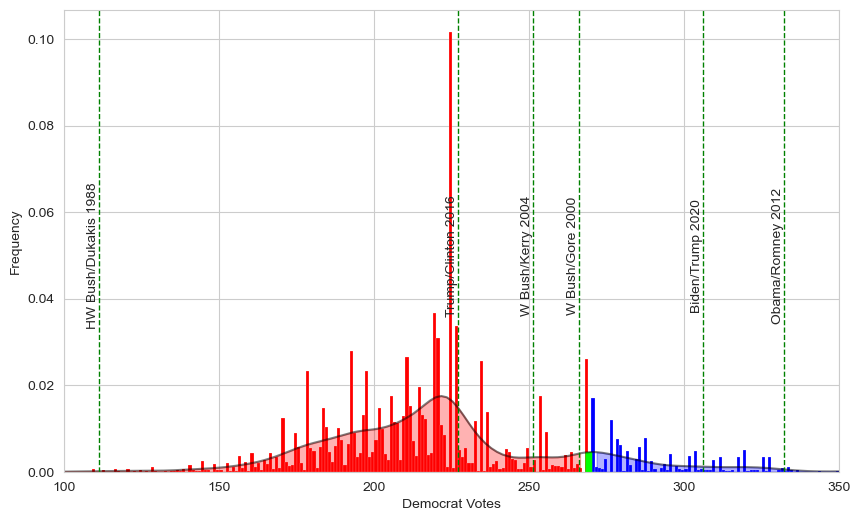

In [112]:

# Plotting the histograms
plt.figure(figsize=(10, 6))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], binwidth=1, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_ec['dem'], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 270), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 268), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x > 268) & (kde_x < 270), color='lime', alpha=1)


# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.xlabel('Democrat Votes')
plt.xlim(100, 350)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    #(365, 'Obama/McCain 2008'),
    #(379, 'Clinton/Dole 1996'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_ec.png')

In [107]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [108]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [109]:
df_win_pct.sort_values('dem')

,dem,gop
NE,0.0000,1.0000
OK,0.0000,1.0000
TN,0.0000,1.0000
SD,0.0000,1.0000
AR,0.0000,1.0000
ID,0.0000,1.0000
KS,0.0000,1.0000
KY,0.0000,1.0000
ME-2,0.0000,1.0000
MS,0.0000,1.0000


In [110]:
df_mean.sort_values('margin')

,dem,gop,margin
TN,0.337830,0.662170,-0.324340
SD,0.338473,0.661527,-0.323054
UT,0.348626,0.651374,-0.302748
OK,0.350987,0.649013,-0.298027
NE,0.390664,0.609336,-0.218672
WV,0.390687,0.609313,-0.218625
MT,0.391887,0.608113,-0.216225
IN,0.400330,0.599670,-0.199341
AL,0.402050,0.597950,-0.195900
MO,0.412933,0.587067,-0.174135
